In [1]:
from pathlib import Path
import pickle
import pandas as pd

from pathlib import Path
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import seaborn as sns
sns.set_theme()
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
plt.rcParams["font.family"] = "Times New Roman"

import mmtbx.f_model
import mmtbx.model
import cctbx.crystal
import cctbx.xray
import iotbx

import sys
sys.path.append(str(Path(Path.home(), "Documents/xray/src")))
# sys.path.append("../src")
import miller_ops
sys.path.append(str(Path(Path.home(), "Documents/xray/data/cifs/scripts")))
import generate_fmodel


In [77]:

data_dir = Path(Path.home(), "Documents/xray/sample_bench/data/7mhf/166_N1")
summary_file = Path(Path(data_dir, "summary_ref_15.csv"))
n_state = 2
cif_name = "7mhf"
n_cond = 2
pdb_file = Path(Path(data_dir, "summary_15/{}_N{}.pdb".format(cif_name, n_state)))
f_obs_file = Path(Path.home(), "Documents/xray/data/cifs/7mhf/{}.cif".format(cif_name))

summary_df = pd.read_csv(summary_file, index_col=0)
summary_df.head()

,index,job_id,cif_name,w_0,pdb,r_free,ff,N,J,w_1,w_2,w_3,w_4,w_5,w_6,w_7,delta,job_cif_str
508,508,5,7mhk,1.0,/wynton/group/sali/mhancock/xray/sample_bench/...,0.293053,88.835005,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.046053,7mhk
3300,3300,19,7mhk,1.0,/wynton/group/sali/mhancock/xray/sample_bench/...,0.274136,714.633937,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027136,"7mhi,7mhk"
8053,8055,35,7mhk,1.0,/wynton/group/sali/mhancock/xray/sample_bench/...,0.263804,7544.013477,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016804,"7mhg,7mhi,7mhk"
12765,12767,48,7mhk,1.0,/wynton/group/sali/mhancock/xray/sample_bench/...,0.262198,1532.903358,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015198,"7mhf,7mhh,7mhi,7mhk"
18083,18085,60,7mhk,1.0,/wynton/group/sali/mhancock/xray/sample_bench/...,0.267385,2278.918229,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020385,"7mhf,7mhh,7mhi,7mhj,7mhk"


In [78]:
entry = summary_df[(summary_df["cif_name"] == cif_name) & (summary_df["N"] == n_state) & (summary_df["J"] == n_cond)].iloc[0]
print(entry["r_free"])
occs = [entry["w_{}".format(i)] for i in range(n_state)]
occs

0.3306839087211977


[0.4606734222979827, 0.5393265777020172]

In [87]:

f_obs = miller_ops.get_miller_array(
        f_obs_file=f_obs_file,
        label="_refln.F_meas_au"
    )

print(f_obs.indices()[0], f_obs.data()[0])

f_obs = miller_ops.clean_miller_array(f_obs)
status_array = miller_ops.get_miller_array(
    f_obs_file=f_obs_file,
    label="_refln.status"
)
flags = status_array.customized_copy(data=status_array.data()=="f")
f_obs, flags = f_obs.common_sets(other=flags)

f_obs = miller_ops.filter_f_obs_resolution(
        f_obs=f_obs,
        d_max=None,
        d_min=None
)
flags = miller_ops.filter_f_obs_resolution(
        f_obs=flags,
        d_max=None,
        d_min=None
)

print(len(f_obs.data()))
print(f_obs.indices()[0], f_obs.data()[0])

crystal_symmetry = f_obs.crystal_symmetry()

(-73, 1, 4) 40.22
37901
(-73, 1, 4) 40.22


In [88]:
model = mmtbx.model.manager(
    model_input=iotbx.pdb.input(str(pdb_file)),
    crystal_symmetry=crystal_symmetry
)

xray_structure = model.get_xray_structure()

n_scatt = int(xray_structure.scatterers().size())
print(type(n_scatt))
print(n_scatt)

n_scatt_per_state = n_scatt//n_state

for i in range(n_scatt_per_state):
    for state in range(n_state):
        xray_structure.scatterers()[i+(state*n_scatt_per_state)].occupancy = occs[state]

xray_structure.scatterers().flags_set_grads(
    state=False
)
xray_structure.scatterers().flags_set_grad_site(
    iselection=xray_structure.all_selection().iselection()
)
xray_structure.scatterers().flags_set_grad_occupancy(
    iselection=xray_structure.all_selection().iselection()
)

f_model_manager = mmtbx.f_model.manager(
    xray_structure=xray_structure,
    f_obs=f_obs,
    r_free_flags=flags,
    target_name="ml",
    max_number_of_bins=1
)
f_model_manager.update_all_scales(apply_scale_k1_to_f_obs=False,remove_outliers=False)

f_obs = f_model_manager.f_obs()
f_model = f_model_manager.f_model()
# print(len(f_obs.indices()), len(f_obs.data()))
# print(f_obs.indices()[0], f_obs.data()[0])

refl_df = pd.DataFrame(
    {
        "d": [f_model_manager.f_obs().d_spacings().data()[i] for i in range(len(f_obs.data()))],
        "f_obs": [f for f in f_obs.data()],
        "f_model": [f for f in f_model.amplitudes().data()]
    }
)
refl_df.head()
refl_df["error"] = (refl_df["f_obs"] - refl_df["f_model"]).abs()/refl_df["f_obs"]
# for i in range(len(f_obs.data())):
#     print(f_model_manager.f_obs().indices()[i], f_model_manager.f_model().amplitudes().data()[i], f_model_manager.f_obs().data()[i])

<class 'int'>
4734


In [89]:
refl_df = pd.DataFrame(columns=["d", "f_obs", "f_model", "bin"])
n_bins = 20
f_obs.setup_binner(n_bins=n_bins)
f_model.use_binning_of(f_obs)
for i_bin in f_obs.binner().range_all():
    f_obs_bin = f_obs.select(f_obs.binner().selection(i_bin))
    f_model_bin = f_model.select(f_model.binner().selection(i_bin))

    n_reflns = len(f_obs_bin.data())

    refln_bin_df = pd.DataFrame()
    refln_bin_df["d"] = [f_obs_bin.d_spacings().data()[i] for i in range(n_reflns)]
    refln_bin_df["f_obs"] = [f for f in f_obs_bin.data()]
    refln_bin_df["f_model"] = [f for f in f_model_bin.data()]
    refln_bin_df["bin"] = [i_bin] * n_reflns

    refl_df = pd.concat([refl_df, refln_bin_df])
refl_df["error"] = (refl_df["f_obs"] - refl_df["f_model"]).abs()/refl_df["f_obs"]


/var/folders/x2/ss4b83151c31mg5h31tlp3ym0000gn/T/ipykernel_15152/3990386059.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  refl_df = pd.concat([refl_df, refln_bin_df])


In [90]:
f_model_manager.r_free()

0.3306837588969997

0
1973
1921
1924
1895
1912
1876
1936
1864
1909
1903
1882
1888
1852
1916
1880
1916
1885
1867
1875


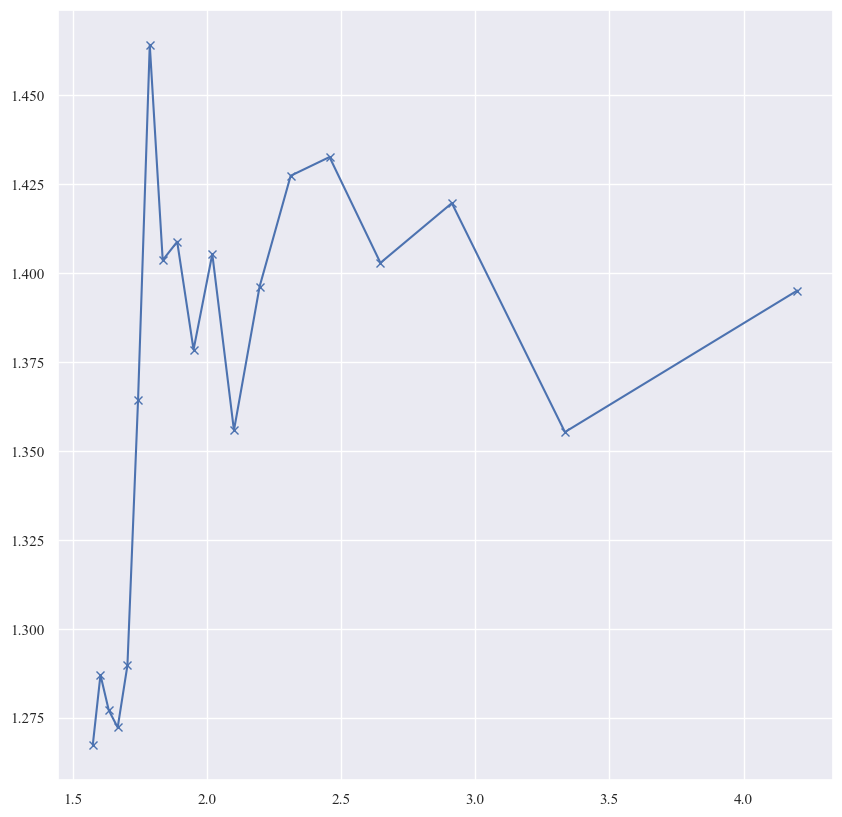

In [91]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

mean_errors = list()
mean_ds = list()
min_ds = list()

# plt.scatter(refl_df["d"], refl_df["error"], s=1)

for i in range(n_bins):
    refln_bin_df = refl_df[refl_df["bin"] == i]
    mean_errors.append(np.mean(refln_bin_df["error"]))

    mean_ds.append(np.mean(refln_bin_df["d"]))
    min_ds.append(np.min(refln_bin_df["d"]))
    print(len(refln_bin_df))

plt.plot(min_ds, mean_errors, "-x")

# ax.set_xlim(1,10)
# ax.set_ylim(0,1)


In [92]:
f_obs.d_max_min()

(48.046812560253, 1.5477237324531918)